In [133]:
import json
import ast
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('bird_data-nov24.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8389373 entries, 0 to 8389372
Data columns (total 8 columns):
battery_level     int64
captive           bool
code              float64
id                object
location          object
location_group    int64
time              object
time_group        object
dtypes: bool(1), float64(1), int64(2), object(4)
memory usage: 456.0+ MB


In [4]:
df.drop(['code', 'captive', 'battery_level', 'location_group'], axis=1, inplace=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8389373 entries, 0 to 8389372
Data columns (total 4 columns):
id            object
location      object
time          object
time_group    object
dtypes: object(4)
memory usage: 256.0+ MB


In [11]:
df['time_group_seconds'] =(pd.to_datetime(df['time_group']) - datetime.datetime(1970,1,1)).dt.total_seconds()
df['date'] = pd.to_datetime(df['time_group']).dt.date
df = add_rounded_time(df) 
df = drop_repeated_data(df)

In [15]:
df = add_lat_long(df)
df['count'] = 1
df['grid_location'] = 0

In [18]:
#Applies a location based on a grid over Oakland to each scooter
df = add_grid_location(df)

In [21]:
#Reforms dataframe to calculate count of scooters in each grid location every 15 min
df = grid_count(df)

In [27]:
og_df = pd.read_csv('bird_data-nov24.csv')
og_df.drop(['code', 'captive', 'battery_level', 'location_group'], axis=1, inplace=True)
og_df['time_group_seconds'] =(pd.to_datetime(og_df['time_group']) - datetime.datetime(1970,1,1)).dt.total_seconds()
og_df['date'] = pd.to_datetime(og_df['time_group']).dt.date
og_df = add_rounded_time(og_df) 
og_df = drop_repeated_data(og_df)
og_df = add_lat_long(og_df)
og_df['count'] = 1
og_df['grid_location'] = 0
og_df = add_grid_location(og_df)
og_df = add_day_of_week(og_df)
og_df = add_rounded_time(og_df)

In [28]:
new_df = add_id_list(df, og_df)
new_df = add_day_of_week(new_df)

new_df = add_idle_and_turnover(new_df)

In [7]:
def add_rounded_time(df, interval=15):
    '''
    Adds a column with the rounded time to the interval specified.
    
    '''
    df['time_of_day'] = pd.to_datetime(df['time_group_seconds'], unit='s').dt.round('15min')  

    df_time = pd.to_datetime(df['time_of_day'])

    df['time_of_day'] = (pd.to_datetime(df['date']) - datetime.datetime(1970,1,1)).dt.total_seconds() + df_time.dt.hour*3600+df_time.dt.minute*60 + df_time.dt.second
    
    
    return df

In [8]:
def drop_repeated_data(df):
    '''
    Removes repeated data based on id and time_group_seconds - this should cut the data down by more than half
    '''
    
    df.drop_duplicates(subset=['id','time_of_day'], keep='first', inplace=True)
    return df

In [14]:
def add_lat_long(df):
    
    df["location"] = df.location.str.replace("'", "\"").map( lambda x: json.loads(x) )
    
    df["latitude"] = df["location"].map( lambda x:x["latitude"] )
    df["longitude"] = df["location"].map( lambda x:x["longitude"] )
    
    df.drop(['location'], axis=1, inplace=True)

    df['latitude'] = df['latitude'].round(5)
    df['longitude'] = df['longitude'].round(5)
    
    return df

In [17]:
def add_grid_location(df, n=42):
    
    '''
    Assigns each data point to a location on the grid according to its lat/long
    '''
    
    top_right = [df['latitude'].max(), df['longitude'].max()]
    top_left = [df['latitude'].min(), df['longitude'].min()]
    
    grid = get_geojson_grid(top_right, top_left, n)
    
    for i, box in enumerate(grid):
        upper_right = box["properties"]["upper_right"]
        lower_left = box["properties"]["lower_left"]
    
        mask = (
            (df.latitude <= upper_right[1]) & (df.latitude >= lower_left[1]) &
            (df.longitude <= upper_right[0]) & (df.longitude >= lower_left[0])
           )
    
        column_name = 'grid_location'
        df.loc[mask, column_name] = i
    
    return df

def get_geojson_grid(upper_right, lower_left, n=6):
    """Returns a grid of geojson rectangles, and computes the exposure in each section of the grid based on the vessel data.

    Parameters
    ----------
    upper_right: array_like
        The upper right hand corner of "grid of grids" (the default is the upper right hand [lat, lon] of the USA).

    lower_left: array_like
        The lower left hand corner of "grid of grids"  (the default is the lower left hand [lat, lon] of the USA).

    n: integer
        The number of rows/columns in the (n,n) grid.

    Returns
    -------

    list
        List of "geojson style" dictionary objects   
    """

    all_boxes = []

    lat_steps = np.linspace(lower_left[0], upper_right[0], n+1)
    lon_steps = np.linspace(lower_left[1], upper_right[1], n+1)

    lat_stride = lat_steps[1] - lat_steps[0]
    lon_stride = lon_steps[1] - lon_steps[0]

    for lat in lat_steps[:-1]:
        for lon in lon_steps[:-1]:
            # Define dimensions of box in grid
            upper_left = [lon, lat + lat_stride]
            upper_right = [lon + lon_stride, lat + lat_stride]
            lower_right = [lon + lon_stride, lat]
            lower_left = [lon, lat]

            # Define json coordinates for polygon
            coordinates = [
                upper_left,
                upper_right,
                lower_right,
                lower_left,
                upper_left
            ]

            geo_json = {"type": "FeatureCollection",
                        "properties":{
                            "lower_left": lower_left,
                            "upper_right": upper_right
                        },
                        "features":[]}

            grid_feature = {
                "type":"Feature",
                "geometry":{
                    "type":"Polygon",
                    "coordinates": [coordinates],
                }
            }

            geo_json["features"].append(grid_feature)

            all_boxes.append(geo_json)

    return all_boxes


In [20]:
def grid_count(df, n=42):
    '''
    For a given time, day of the week create df of number of scooters in each grid location
    '''
    
    #COMBINE UNIQUE DATE AND UNIQUE ROUNDED TIME INTO 1 LOOP INSTEAD OF 2
    
    new_df = pd.DataFrame()
    for unique_rounded_time in df['time_of_day'].unique():
        for unique_grid_location in range(n**2):
            if ((df['time_of_day'] == unique_rounded_time) & (df['grid_location'] == unique_grid_location)).any():
                continue
            else:
                new_df = new_df.append({'time_of_day':unique_rounded_time, 'grid_location':unique_grid_location}, ignore_index=True)
    new_df['grid_location'] = new_df['grid_location'].astype(int)                
    
    df = df.groupby(['time_of_day', 'grid_location']).size().reset_index(name='counts')
    df3 = pd.concat([df,new_df], sort=False)
    df3.fillna(value=0, inplace=True)
    df3.sort_values(by=['grid_location', 'time_of_day'], inplace=True)
    #for a given date and rounded time - check to see if there is a grid location, if not set count to 0.
    
    #df = df.groupby(['grid_location']).agg(['count'])
    return df3

In [24]:
def add_day_of_week(df):
    
    df['date'] = pd.to_datetime(df['time_of_day'], unit='s').dt.date
    
    #df['date'] = pd.to_datetime(df['time_of_day'], unit='s').dt.round("D")
    df['day_of_week'] = pd.to_datetime(df['date']).dt.day_name()
    
    
    return df

def add_id_list(df, og_df):

    g = og_df.groupby(['grid_location', 'time_of_day'])['id'].apply(list).reset_index(name='id_list')

    merger_df = pd.merge(df, g, on=['grid_location', 'time_of_day'], how='outer')
    
    isnull = merger_df.id_list.isnull()

    merger_df.loc[isnull, 'id_list'] = [ [[]] * isnull.sum() ]
    
    return merger_df

def add_idle_and_turnover(merger_df):
    
    group1_master = pd.DataFrame()
    group2_master = pd.DataFrame()
    for grid_location in merger_df['grid_location'].unique():
        
        group1 = merger_df[merger_df['grid_location']==grid_location].iloc[:-1]
        group1.reset_index(inplace=True)
        group1_master = group1_master.append(group1, ignore_index=True)
        
        group2 = merger_df[merger_df['grid_location']==grid_location].iloc[1:]
        group2.reset_index(inplace=True)
        group2_master = group2_master.append(group2, ignore_index=True)

    df_id_list = group1_master.merge(group2_master, how='outer', left_index=True, right_index=True)
    
    df_id_list['idle'] = df_id_list.apply(lambda x: [i for i in x['id_list_x'] if i.lower() in x['id_list_y']], axis=1)
    
    df_id_list['turn_over'] = df_id_list.apply(lambda x: [i for i in x['id_list_y'] if i.lower() not in x['id_list_x']], axis=1)
    
    df_id_list['num_idle_15min'] = df_id_list['idle'].str.len()
    df_id_list['num_turn_over_15min'] = df_id_list['turn_over'].str.len()
    
    
    df_id_list['time'] = df_id_list['time_of_day_y'] - (pd.to_datetime(df_id_list['date_y']) - datetime.datetime(1970,1,1)).dt.total_seconds()
    
    df_id_list.drop(['index_x','time_of_day_x','grid_location_x','counts_x', 'id_list_x', 'date_x', 'day_of_week_x'], axis=1, inplace=True)
    df_id_list = df_id_list.rename(index=str, columns={"time_of_day_y": "time_of_day", "grid_location_y":"grid_location", "counts_y":"counts", "id_list_y":"id_list", "date_y":"date", "day_of_week_y":"day_of_week"})
    
    df_id_list = pd.concat([df_id_list, pd.get_dummies(df_id_list['day_of_week'])], axis=1)
    df_id_list.drop(['index_y','day_of_week','date','id_list','idle', 'turn_over'], axis =1, inplace=True)
    
    return df_id_list

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 475051 entries, 0 to 8388872
Data columns (total 10 columns):
id                    475051 non-null object
time                  475051 non-null object
time_group            475051 non-null object
time_group_seconds    475051 non-null float64
date                  475051 non-null object
time_of_day           475051 non-null float64
latitude              475051 non-null float64
longitude             475051 non-null float64
count                 475051 non-null int64
grid_location         475051 non-null int64
dtypes: float64(4), int64(2), object(4)
memory usage: 39.9+ MB


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1044288 entries, 31983 to 939138
Data columns (total 3 columns):
time_of_day      1044288 non-null float64
grid_location    1044288 non-null int64
counts           1044288 non-null float64
dtypes: float64(2), int64(1)
memory usage: 31.9 MB


In [23]:
df.to_csv('bird_data-nov24_step1')

In [30]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1042524 entries, 0 to 1042523
Data columns (total 13 columns):
time_of_day            1042524 non-null float64
grid_location          1042524 non-null int64
counts                 1042524 non-null float64
num_idle_15min         1042524 non-null int64
num_turn_over_15min    1042524 non-null int64
time                   1042524 non-null float64
Friday                 1042524 non-null uint8
Monday                 1042524 non-null uint8
Saturday               1042524 non-null uint8
Sunday                 1042524 non-null uint8
Thursday               1042524 non-null uint8
Tuesday                1042524 non-null uint8
Wednesday              1042524 non-null uint8
dtypes: float64(3), int64(3), uint8(7)
memory usage: 62.6+ MB


In [31]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import recall_score

In [32]:
def MVP(df):
    '''
    even more mvp than mvp
    '''
    
    y = df['counts']
    X = df.drop('counts', axis=1)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)
    
    
    linreg=LinearRegression()
    linreg.fit(X_train, y_train)
    
    y_pred = linreg.predict(X_test).reshape(-1,1)
    y_test = np.array(y_test).reshape(-1,1)
    
    #print(y_pred - y_test)
    #print (np.shape(y_pred), np.shape(y_test))
    
    #print(recall_score(y_test, y_pred))
    
    #print(y_pred)
    print(linreg.coef_)
    
    return linreg.score(X_test, y_test)


In [33]:
MVP(new_df)

[-2.08977182e-20  1.45445721e-16  1.00000000e+00  1.00000000e+00
  7.04731412e-19 -4.54001309e-16 -2.01467692e-15 -6.12224916e-16
 -1.17291425e-15 -2.68030977e-16 -7.29745696e-16 -2.19706318e-16]


1.0

In [37]:
len(new_df[new_df['counts']==0])/len(new_df)

0.8993107113121617

In [91]:
def RandFor(df):
    
    
    
    y = df['counts']
    X = df.drop('counts', axis=1)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)
    
    
    
    rf = RandomForestRegressor()
    rf.fit(X_train, y_train)
    
    tscv = TimeSeriesSplit(n_splits=5)
    for train_index, test_index in tscv.split(X_train):

        X_train1, X_test1 = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train1, y_test1 = y_train[train_index], y_train[test_index]
        
        print(rf.score(X_test1, y_test1))
    
    
    y_predict = rf.predict(X_test)
    
    
    print(y_test.max(), y_predict.max())
    print(rf.score(X_test, y_test))
    
    output = open('rf_model.pkl', 'wb')
    pickle.dump(rf, output)
    
    y_predict_full = rf.predict(X)
    residplot(y_predict_full, y)
    
    return rf

0.9999798706063756
0.9984390867830387
0.9998448251780806
0.9999749867316335
0.9999967821090501
4.0 4.0
1.0


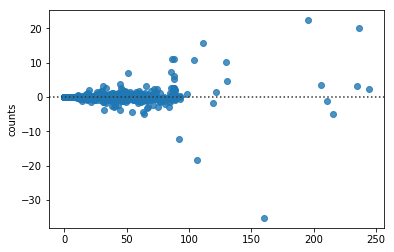

In [92]:
random_forest = RandFor(new_df)

In [78]:
import pickle

In [88]:
from seaborn import residplot

In [93]:
new_df.head()

,time_of_day,grid_location,counts,num_idle_15min,num_turn_over_15min,time,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,1.542049e+09,0,0.0,0,0,68400.0,0,1,0,0,0,0,0
1,1.542050e+09,0,0.0,0,0,69300.0,0,1,0,0,0,0,0
2,1.542051e+09,0,0.0,0,0,70200.0,0,1,0,0,0,0,0
3,1.542052e+09,0,0.0,0,0,71100.0,0,1,0,0,0,0,0
4,1.542053e+09,0,0.0,0,0,72000.0,0,1,0,0,0,0,0


In [104]:
new_df['redistribute_here_score'] = (new_df['num_turn_over_15min'] / (new_df['num_idle_15min'] + 1)) * (new_df['counts'])

In [105]:
np.sort(np.array(new_df['redistribute_here_score']))

array([ 0. ,  0. ,  0. , ..., 31. , 34. , 46.5])

In [114]:
new_df.describe()

,time_of_day,grid_location,counts,num_idle_15min,num_turn_over_15min,time,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,redistribute_here_score
count,1.042524e+06,1.042524e+06,1.042524e+06,1.042524e+06,1.042524e+06,1.042524e+06,1.042524e+06,1.042524e+06,1.042524e+06,1.042524e+06,1.042524e+06,1.042524e+06,1.042524e+06,1.042524e+06
mean,1.542416e+09,8.815000e+02,4.551416e-01,4.072990e-01,4.784254e-02,4.723249e+04,1.167513e-01,1.505922e-01,1.167513e-01,1.167513e-01,1.167513e-01,2.318105e-01,1.505922e-01,1.460174e-02
std,2.137926e+05,5.092231e+02,2.702850e+00,2.429506e+00,6.085957e-01,2.821782e+04,3.211238e-01,3.576511e-01,3.211238e-01,3.211238e-01,3.211238e-01,4.219888e-01,3.576511e-01,1.761148e-01
min,1.542049e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.542230e+09,4.407500e+02,0.000000e+00,0.000000e+00,0.000000e+00,1.440000e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.542412e+09,8.815000e+02,0.000000e+00,0.000000e+00,0.000000e+00,5.490000e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,1.542594e+09,1.322250e+03,0.000000e+00,0.000000e+00,0.000000e+00,7.110000e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,1.542776e+09,1.763000e+03,2.570000e+02,2.430000e+02,1.270000e+02,8.550000e+04,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,4.650000e+01


In [124]:
new_df[new_df['time_of_day'] == 1542049200]['counts'].sum()

577.0

In [126]:
new_df.to_csv('bird_data-nov24_step2.csv')

In [130]:
og_df.to_csv('individual_scooter_data.csv')

In [132]:
new_df.head()

,time_of_day,grid_location,counts,num_idle_15min,num_turn_over_15min,time,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,redistribute_here_score
0,1.542049e+09,0,0.0,0,0,68400.0,0,1,0,0,0,0,0,0.0
1,1.542050e+09,0,0.0,0,0,69300.0,0,1,0,0,0,0,0,0.0
2,1.542051e+09,0,0.0,0,0,70200.0,0,1,0,0,0,0,0,0.0
3,1.542052e+09,0,0.0,0,0,71100.0,0,1,0,0,0,0,0,0.0
4,1.542053e+09,0,0.0,0,0,72000.0,0,1,0,0,0,0,0,0.0


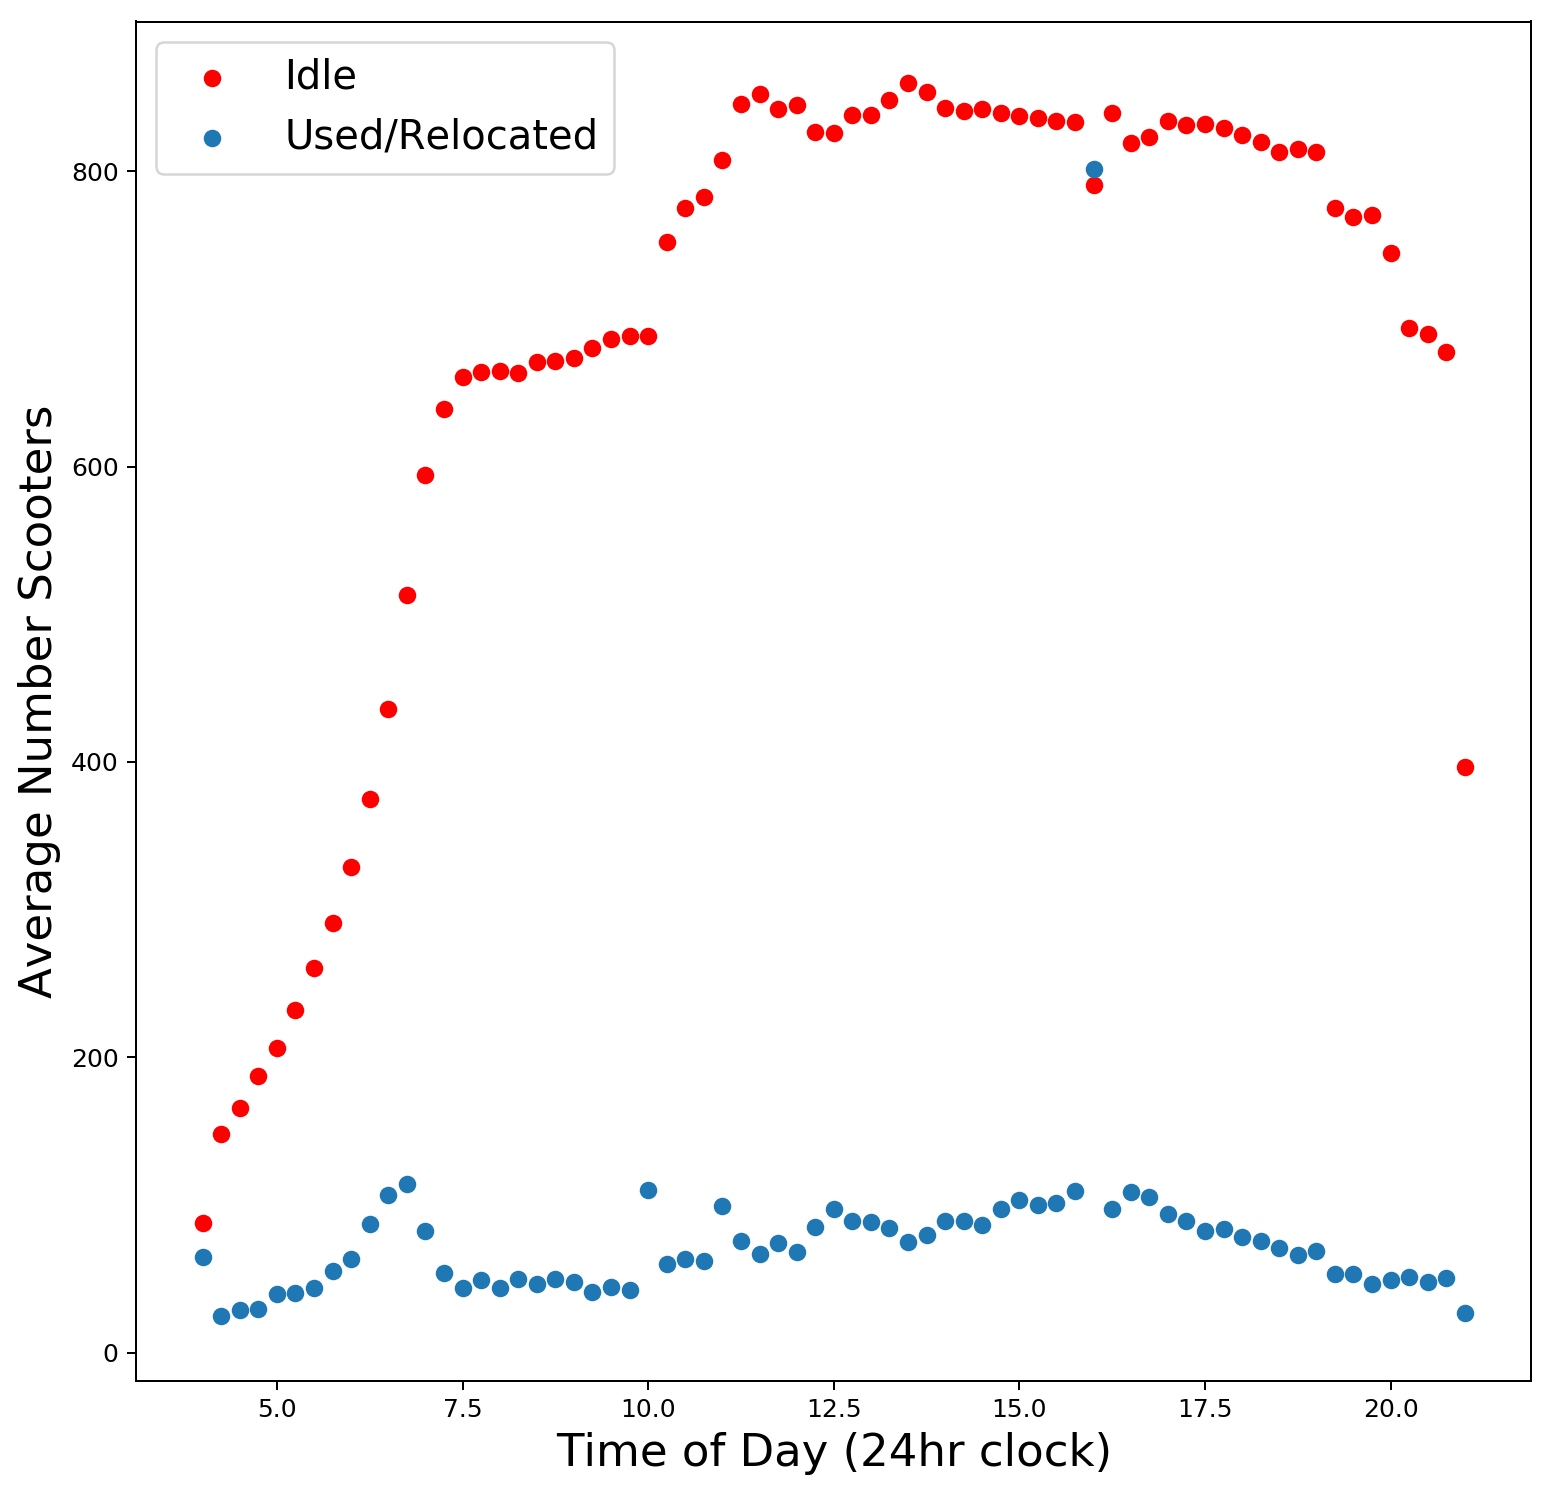

In [201]:
plt_df = new_df.sort_values('time')
list_idle = []
for unique in plt_df['time'].unique():
    list_idle.append(plt_df[plt_df['time']==unique]['num_idle_15min'].sum()/9)
list_idle
list_time = list(plt_df['time'].unique())
#plt_df.head()
plt.figure(figsize=(10, 10), dpi=180)
plt.scatter(list_time_hr, list_idle, c='r', label='Idle');

plt.scatter(list_time_hr, list_turn_over, label='Used/Relocated');


#plt.title('Idle and Used/Relocated Scooters - Over 8 Days', fontsize=20)
plt.xlabel('Time of Day (24hr clock)', fontsize=18)
plt.ylabel('Average Number Scooters', fontsize=18)
plt.legend(loc='upper left', fontsize=16)
#plt.show()
plt.savefig('Idle and Used Scooters')

In [180]:

list_turn_over = []
for unique in plt_df['time'].unique():
    list_turn_over.append(plt_df[plt_df['time']==unique]['num_turn_over_15min'].sum()/9)

Text(0,0.5,'Average Number of Scooters Used')

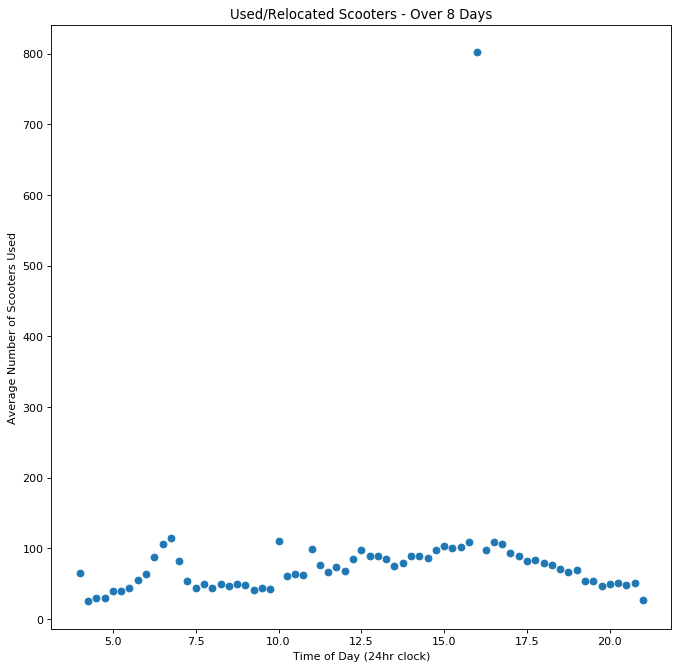

In [189]:
plt.figure(figsize=(10, 10), dpi=80)

plt.scatter(list_time_hr, list_turn_over);

plt.title('Used/Relocated Scooters - Over 8 Days')
plt.xlabel('Time of Day (24hr clock)')
plt.ylabel('Average Number of Scooters Used')

In [ ]:
0 = 4pm
20000 = 5.5hrs = 9:30pm

In [163]:
list_time_hr = np.array(list_time)
list_time_hr = np.divide(list_time_hr, 3600)
list_time_hr = list_time_hr+16

In [164]:

for i in range(len(list_time_hr)):
    if list_time_hr[i] > 24:
        print(list_time_hr[i])
        list_time_hr[i] = list_time_hr[i]-24
list_time_hr

28.0
28.25
28.5
28.75
29.0
29.25
29.5
29.75
30.0
30.25
30.5
30.75
31.0
31.25
31.5
31.75
32.0
32.25
32.5
32.75
33.0
33.25
33.5
33.75
34.0
34.25
34.5
34.75
35.0
35.25
35.5
35.75
36.0
36.25
36.5
36.75
37.0
37.25
37.5
37.75
38.0
38.25
38.5
38.75
39.0
39.25
39.5
39.75


array([16.  , 16.25, 16.5 , 16.75, 17.  , 17.25, 17.5 , 17.75, 18.  ,
       18.25, 18.5 , 18.75, 19.  , 19.25, 19.5 , 19.75, 20.  , 20.25,
       20.5 , 20.75, 21.  ,  4.  ,  4.25,  4.5 ,  4.75,  5.  ,  5.25,
        5.5 ,  5.75,  6.  ,  6.25,  6.5 ,  6.75,  7.  ,  7.25,  7.5 ,
        7.75,  8.  ,  8.25,  8.5 ,  8.75,  9.  ,  9.25,  9.5 ,  9.75,
       10.  , 10.25, 10.5 , 10.75, 11.  , 11.25, 11.5 , 11.75, 12.  ,
       12.25, 12.5 , 12.75, 13.  , 13.25, 13.5 , 13.75, 14.  , 14.25,
       14.5 , 14.75, 15.  , 15.25, 15.5 , 15.75])

In [177]:
list_idle

[790.8888888888889,
 839.7777777777778,
 818.8888888888889,
 823.2222222222222,
 833.8888888888889,
 831.2222222222222,
 832.2222222222222,
 829.6666666666666,
 824.3333333333334,
 819.6666666666666,
 813.0,
 815.4444444444445,
 813.4444444444445,
 775.3333333333334,
 769.2222222222222,
 770.3333333333334,
 744.8888888888889,
 694.1111111111111,
 690.1111111111111,
 677.4444444444445,
 396.8888888888889,
 87.44444444444444,
 148.11111111111111,
 165.55555555555554,
 187.0,
 206.11111111111111,
 232.11111111111111,
 260.1111111111111,
 290.77777777777777,
 329.0,
 375.22222222222223,
 435.55555555555554,
 513.1111111111111,
 594.2222222222222,
 639.0,
 660.5555555555555,
 663.7777777777778,
 664.8888888888889,
 663.4444444444445,
 671.1111111111111,
 671.6666666666666,
 673.4444444444445,
 680.1111111111111,
 686.5555555555555,
 688.5555555555555,
 688.4444444444445,
 752.1111111111111,
 775.2222222222222,
 782.6666666666666,
 807.4444444444445,
 845.3333333333334,
 852.2222222222222,
 